# Семинар 10 - Ранжирование на деревянных моделях

In [2]:
import numpy as np
import pandas as pd
import torch

import math

import numpy as np
import torch
from catboost.datasets import msrank_10k
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from typing import List

from utils import dcg, ndcg

seed = 42
np.random.seed(seed)

D:\Anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<a id="Content"></a>
# Содержание
0. [ListNet](#0)
   - [Подготовка данных](#0.1)
   - [Подготовка этапов обучения](#0.2)
   - [Обучение](#0.3)
2. [LambdaRank](#1)
3. [Полезные ссылки](#2)

<a id="0"></a>
# 0. ListNet

In [3]:
class ListNet(torch.nn.Module):
    def __init__(self, num_input_features: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(num_input_features, self.hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_dim, 1),
        )

    def forward(self, input_1: torch.Tensor) -> torch.Tensor:
        logits = self.model(input_1)

        return logits
    
    
def init_weights(module):
    if isinstance(module, torch.nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=1.0)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()
    elif isinstance(module, torch.nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
        
        
def create_model(listnet_num_input_features: int, listnet_hidden_dim: int) -> torch.nn.Module:
    torch.manual_seed(0)
    net = ListNet(listnet_num_input_features, listnet_hidden_dim)
    init_weights(net)

    return net

<a id="0.1"></a>
## 0.1. Подготовка данных

Описание датасета [msrank_10k](https://catboost.ai/en/docs/concepts/python-reference_datasets_msrank_10k)

In [4]:
train_df, test_df = msrank_10k()

In [13]:
train_df[train_df[1] == 1]

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,1,3,3,0,0,3,1.000000,1.000000,0.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,2.0,1,3,0,3,0,3,1.000000,0.000000,1.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,0.0,1,3,0,2,0,3,1.000000,0.000000,0.666667,...,45,3,1,124,3344,14,67,0,0,0.0
3,2.0,1,3,0,3,0,3,1.000000,0.000000,1.000000,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,1.0,1,3,0,3,0,3,1.000000,0.000000,1.000000,...,64,5,7,256,49697,1,13,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,1,3,0,3,0,3,1.000000,0.000000,1.000000,...,44,5,30,23860,63634,3,4,0,0,0.0
82,0.0,1,3,2,2,0,3,1.000000,0.666667,0.666667,...,33,2,2,11886,29019,3,7,0,0,0.0
83,1.0,1,3,3,3,3,3,1.000000,1.000000,1.000000,...,57,0,3,2468,24730,23,80,0,0,0.0
84,1.0,1,2,0,2,0,2,0.666667,0.000000,0.666667,...,35,1753,9,6389,30537,1,5,0,20,42.6


In [14]:
def get_data() -> List[np.ndarray]:
    train_df, test_df = msrank_10k()

    X_train = train_df.drop([0, 1], axis=1).values
    y_train = train_df[0].values
    query_ids_train = train_df[1].values.astype(int)

    X_test = test_df.drop([0, 1], axis=1).values
    y_test = test_df[0].values
    query_ids_test = test_df[1].values.astype(int)

    return [X_train, y_train, query_ids_train, X_test, y_test, query_ids_test]

**Задание 0:** Отмасштабируйте данные по каждому уникальному запросу

In [16]:
def scale_features_in_query_groups(inp_feat_array: np.ndarray, inp_query_ids: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    # scale each data by query

    return inp_feat_array

**Задание 1:** С помощью реализованной выше функции отмасштабируйте обучающий и тестовый наборы. Затем результат функции конвертируйте в torch.FloatTensor

In [17]:
def prepare_data() -> List[np.ndarray]:
    X_train, y_train, query_ids_train, X_test, y_test, query_ids_test = get_data()
    # YOUR CODE HERE 
    # 1. scale train and test data 
    # 2. convert data to torch
    
    return X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test

In [18]:
X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test = prepare_data()

<a id="0.2"></a>
## 0.2. Подготовка этапов обучения

In [19]:
def ndcg_k(ys_true: torch.Tensor, ys_pred: torch.Tensor, ndcg_top_k: int) -> float:
    try:
        return ndcg(ys_true[:ndcg_top_k], ys_pred[:ndcg_top_k])
    except ZeroDivisionError:
        return float(0)

**Задание 2:** Реализуйте функцию для подсчёта классической кросс-энтропии:
$\displaystyle L(y^{(i)}, z^{(i)}) = -\sum^n_{j = 1} P_{y^{(i)}}(j) \log(P_{z^{(i)}}(j))$,

In [20]:
def calc_loss(batch_ys: torch.FloatTensor, batch_pred: torch.FloatTensor) -> torch.FloatTensor:
    # YOUR CODE HERE
    pass

In [21]:
n_epochs: int = 5
listnet_hidden_dim: int = 30
lr: float = 0.001
ndcg_top_k: int = 10
num_input_features = X_train.shape[1]


model = create_model(num_input_features, listnet_hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

**Задание 3:** Реализуйте функцию обучения на одной эпохе

In [22]:
def _train_one_epoch(model, optimizer, X_train, ys_train, query_ids_train) -> None:
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    for id in np.unique(query_ids_train):
        idxs = query_ids_train == id
        x = X_train[idxs]
        ys = ys_train[idxs]

        with torch.enable_grad():
        # YOUR CODE HERE

In [23]:
_train_one_epoch(model, optimizer, X_train, ys_train, query_ids_train)

In [24]:
def _eval_test_set(model, X_test, ys_test, query_ids_test) -> float:
    with torch.no_grad():
        model.eval()
        ndcgs = []

        for id in np.unique(query_ids_test):
            idxs = query_ids_test == id
            x = X_test[idxs]
            ys = ys_test[idxs]
            pred = model(x)

            score = ndcg_k(ys.squeeze(), pred.squeeze(), ndcg_top_k)
            ndcgs.append(score)

    return np.mean(ndcgs)

In [25]:
_eval_test_set(model, X_test, ys_test, query_ids_test)

0.6616547163739617

<a id="0.3"></a>
## 0.3. Обучение

In [26]:
def fit(n_epochs, model, optimizer, X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test) -> List[float]:
    val_ndcg = []
    
    for epoch in tqdm(range(n_epochs)):
        _train_one_epoch(model, optimizer, X_train, ys_train, query_ids_train)
        val_metric = _eval_test_set(model, X_test, ys_test, query_ids_test)

        val_ndcg.append(val_metric)

    return val_ndcg

In [27]:
n_epochs: int = 100
listnet_hidden_dim: int = 10
lr: float = 0.001
ndcg_top_k: int = 10
num_input_features = X_train.shape[1]


model = create_model(num_input_features, listnet_hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


val_ndcg = fit(n_epochs, model, optimizer, X_train, ys_train, query_ids_train, X_test, ys_test, query_ids_test)

  0%|          | 0/100 [00:00<?, ?it/s]

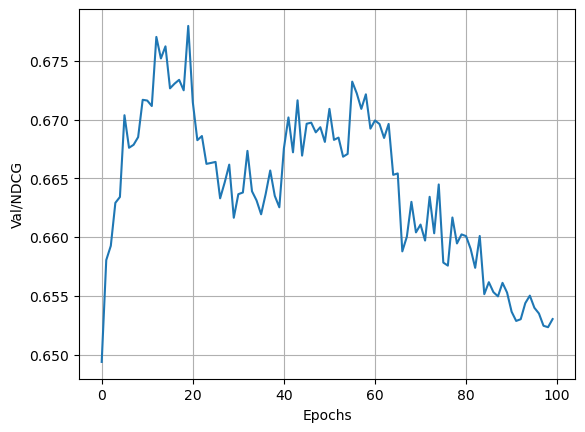

In [28]:
plt.plot(val_ndcg)
plt.xlabel('Epochs')
plt.ylabel('Val/NDCG')
plt.grid()
plt.show()

<a id="1"></a>
# 1. LambdaRank

$$p_{ij} = p(x_i > x_j) = \frac {1}{1 + e^{s_i - s_j}}$$

$$\lambda_{ij} = \frac{\partial L_{ij}}{\partial s_i} = \left(0.5 * (1 - S_{ij}) - \frac {1} {1 + e^{s_i - s_j}}\right) = -\frac{\partial L_{ij}}{\partial s_j}$$

$$\lambda = \left(0.5 * (1 - S_{ij}) - \frac {1} {1 + e^{s_i - s_j}}\right) |\Delta nDCG|$$

$$\Delta nDCG = \frac {1} {IdealDCG} (2^i - 2^j) \left(\frac {1} {log_2(1+i)} - \frac {1} {log_2(1+j)}\right)$$ 

$\Delta nDCG$ - насколько поменяется метрика nDCG, если i и j поменяются местами в топе

In [52]:
# в y_true лежат оценки релевантности
y_true = torch.LongTensor([[5, 3, 2, 5, 1, 1]]).reshape(-1, 1)
y_pred = torch.FloatTensor([3.2, 0.4, -0.1, -2.1, 0.5, 0.01]).reshape(-1, 1)

In [54]:
def compute_lambdas(y_true, y_pred, ndcg_scheme='exp2'):
    # рассчитаем нормировку, IdealDCG
    ideal_dcg = dcg(y_true, y_true, ndcg_scheme)
    N = 1 / ideal_dcg
    
    # рассчитаем порядок документов согласно оценкам релевантности
    _, rank_order = torch.sort(y_true, descending=True, axis=0)
    rank_order += 1
    
    with torch.no_grad():
        # получаем все попарные разницы скоров в батче
        pos_pairs_score_diff = 1.0 + torch.exp((y_pred - y_pred.t()))
        
        # поставим разметку для пар, 1 если первый документ релевантнее
        # -1 если второй документ релевантнее
        Sij = compute_labels_in_batch(y_true)
        # посчитаем изменение gain из-за перестановок
        gain_diff = compute_gain_diff(y_true, ndcg_scheme)
        
        # посчитаем изменение знаменателей-дискаунтеров
        decay_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
        # посчитаем непосредственное изменение nDCG
        delta_ndcg = torch.abs(N * gain_diff * decay_diff)
        # посчитаем лямбды
        lambda_update =  (0.5 * (1 - Sij) - 1 / pos_pairs_score_diff) * delta_ndcg
        lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)
        
        return Sij, gain_diff, decay_diff, delta_ndcg, lambda_update
    
    
def compute_labels_in_batch(y_true):
    
    # разница релевантностей каждого с каждым объектом
    rel_diff = y_true - y_true.t()
    
    # 1 в этой матрице - объект более релевантен
    pos_pairs = (rel_diff > 0).type(torch.float32)
    
    # 1 тут - объект менее релевантен
    neg_pairs = (rel_diff < 0).type(torch.float32)
    Sij = pos_pairs - neg_pairs
    return Sij


def compute_gain_diff(y_true, gain_scheme):
    if gain_scheme == "exp2":
        gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.t())
    elif gain_scheme == "diff":
        gain_diff = y_true - y_true.t()
    else:
        raise ValueError(f"{gain_scheme} method not supported")
    return gain_diff

In [55]:
y_pred - y_pred.t()

tensor([[ 0.0000,  2.8000,  3.3000,  5.3000,  2.7000,  3.1900],
        [-2.8000,  0.0000,  0.5000,  2.5000, -0.1000,  0.3900],
        [-3.3000, -0.5000,  0.0000,  2.0000, -0.6000, -0.1100],
        [-5.3000, -2.5000, -2.0000,  0.0000, -2.6000, -2.1100],
        [-2.7000,  0.1000,  0.6000,  2.6000,  0.0000,  0.4900],
        [-3.1900, -0.3900,  0.1100,  2.1100, -0.4900,  0.0000]])

In [56]:
y_true - y_true.t()

tensor([[ 0,  2,  3,  0,  4,  4],
        [-2,  0,  1, -2,  2,  2],
        [-3, -1,  0, -3,  1,  1],
        [ 0,  2,  3,  0,  4,  4],
        [-4, -2, -1, -4,  0,  0],
        [-4, -2, -1, -4,  0,  0]])

In [57]:
Sij, gain_diff, decay_diff, delta_ndcg, lambda_update = compute_lambdas(y_true, y_pred)

In [58]:
Sij

tensor([[ 0.,  1.,  1.,  0.,  1.,  1.],
        [-1.,  0.,  1., -1.,  1.,  1.],
        [-1., -1.,  0., -1.,  1.,  1.],
        [ 0.,  1.,  1.,  0.,  1.,  1.],
        [-1., -1., -1., -1.,  0.,  0.],
        [-1., -1., -1., -1.,  0.,  0.]])

In [59]:
gain_diff

tensor([[  0.,  24.,  28.,   0.,  30.,  30.],
        [-24.,   0.,   4., -24.,   6.,   6.],
        [-28.,  -4.,   0., -28.,   2.,   2.],
        [  0.,  24.,  28.,   0.,  30.,  30.],
        [-30.,  -6.,  -2., -30.,   0.,   0.],
        [-30.,  -6.,  -2., -30.,   0.,   0.]])

In [60]:
# пример вычисления элемента gain diff для первого (релевантность 5) и последнего документа (1); 
# для первого (5) и второго (3) документа
(2**5 - 1) - (2**1 -1), (2**5 - 1) - (2**3-1)

(30, 24)

In [61]:
decay_diff

tensor([[ 0.0000,  0.5693,  0.3691,  0.5000,  0.6131,  0.6438],
        [-0.5693,  0.0000, -0.2003, -0.0693,  0.0438,  0.0745],
        [-0.3691,  0.2003,  0.0000,  0.1309,  0.2441,  0.2747],
        [-0.5000,  0.0693, -0.1309,  0.0000,  0.1131,  0.1438],
        [-0.6131, -0.0438, -0.2441, -0.1131,  0.0000,  0.0306],
        [-0.6438, -0.0745, -0.2747, -0.1438, -0.0306,  0.0000]])

In [62]:
# посчитаем изменение знаменателей-дискаунтеров для первого и последнего документа
(1 / np.log2(1+1)) - (1 / np.log2(1+6))

0.6437928128919779

In [63]:
delta_ndcg

tensor([[0.0000, 0.2436, 0.1842, 0.0000, 0.3279, 0.3443],
        [0.2436, 0.0000, 0.0143, 0.0297, 0.0047, 0.0080],
        [0.1842, 0.0143, 0.0000, 0.0654, 0.0087, 0.0098],
        [0.0000, 0.0297, 0.0654, 0.0000, 0.0605, 0.0769],
        [0.3279, 0.0047, 0.0087, 0.0605, 0.0000, 0.0000],
        [0.3443, 0.0080, 0.0098, 0.0769, 0.0000, 0.0000]])

In [64]:
lambda_update

tensor([[-0.0548],
        [ 0.0303],
        [ 0.0587],
        [-0.2099],
        [ 0.0851],
        [ 0.0906]])

In [65]:
for _ in range(100):
    _, _, _, _, lambda_update = compute_lambdas(y_true, y_pred)
    y_pred -= lambda_update

In [66]:
rank_indexes = torch.argsort(y_pred, dim=0, descending=True)

In [67]:
y_pred

tensor([[ 4.3905],
        [-0.1219],
        [-1.0463],
        [ 2.0759],
        [-1.5135],
        [-1.8746]])

In [68]:
y_true[rank_indexes]

tensor([[[5]],

        [[5]],

        [[3]],

        [[2]],

        [[1]],

        [[1]]])

In [69]:
# полностью правильное ранжирование
torch.sort(y_true, dim=0, descending=True)[0]

tensor([[5],
        [5],
        [3],
        [2],
        [1],
        [1]])

In [70]:
y_true = torch.LongTensor([[5,3,2,5,1,1]]).reshape(-1,1)

# совсем плохие предсказанные скоры в начале
y_pred = torch.FloatTensor([-3.0, 2.0, 3.0, -4.0, 6.0, 8.5]).reshape(-1,1)

In [71]:
ndcg(y_true, y_pred)

0.6784099316652937

In [72]:
for _ in range(100):
    _, _, _, _, lambda_update = compute_lambdas(y_true, y_pred)
    y_pred -= lambda_update

In [73]:
ndcg(y_true, y_pred)

1.0

In [74]:
# полностью правильное ранжирование при увеличении количества итераций
y_pred

tensor([[6.2690],
        [1.2374],
        [0.5772],
        [3.6842],
        [0.3482],
        [0.3840]])

<a id="2"></a>
## 2. Полезные ссылки

Что посмотреть:
1. [Вывод](https://www.youtube.com/watch?v=UfSrgoguDrs&ab_channel=SergeyNikolenko) RankNet и LambdaNet